In [1]:
from tonic import transforms, datasets

In [2]:
# This downloads the test set of the Neuromorphic MNIST dataset
test_dataset = datasets.NMNIST('data', train=False)

# Loads the first sample, which contains events and a corresponding label
sample_events, sample_label = test_dataset[0]

In [3]:
import numpy as np

# Check if the array is a numpy array
assert isinstance(sample_events, np.ndarray)

# Check if the array is a structured array
assert sample_events.dtype.names is not None

# Check if the array has the correct fields
assert 't' in sample_events.dtype.names
assert 'x' in sample_events.dtype.names
assert 'y' in sample_events.dtype.names
assert 'p' in sample_events.dtype.names

In [4]:
# Create a time surface transform from events. Keep in mind that Tonic works with microsecond resolution.
surf_transform = transforms.ToTimesurface(dt=100000, tau=100000, sensor_size=test_dataset.sensor_size)

# Apply the transform to the sample events to create time surfaces
surfs = surf_transform(sample_events)

# Check the shape of the time surfaces. One sample is roughly 300 000 microseconds long, 
# and the time surface has a dt of 100 000 microseconds, which results in 3-4 time 
# surfaces. The time surface also uses two polarities for ON and OFF events, hence two 
# channels, and has a spatial size of 34x34 pixels.

print(surfs.shape)

(3, 2, 34, 34)


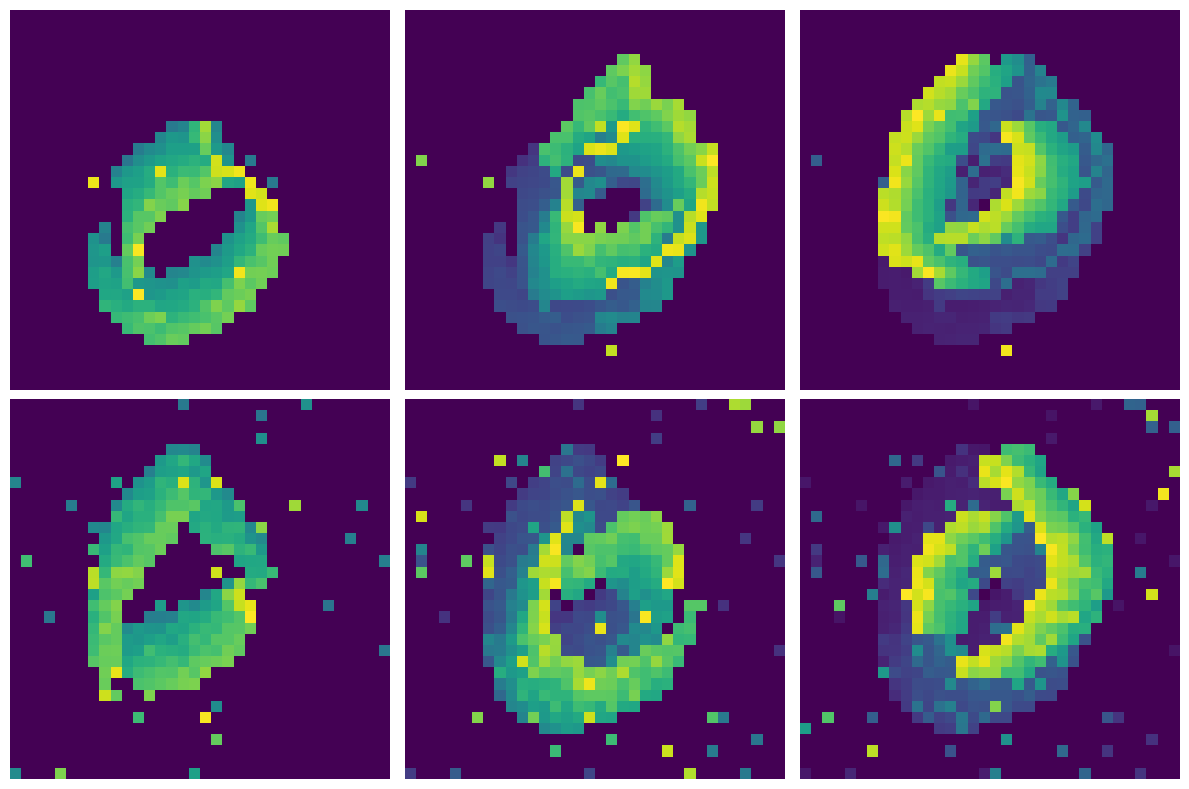

In [5]:
import matplotlib.pyplot as plt


def visualize_surfaces(surfaces):
    n_surfaces = surfaces.shape[0]
    n_channels = surfaces.shape[1]
    fig, axs = plt.subplots(n_channels, n_surfaces, figsize=(12, 8))
    index = 0
    for i in range(n_surfaces):
        for j in range(n_channels):
            row = index % n_channels
            col = index // n_channels 
            axs[row, col].imshow(surfs[i, j])
            axs[row, col].axis('off')
            index += 1
    plt.tight_layout()
    plt.show()

visualize_surfaces(surfs)

(3, 1, 14, 14)


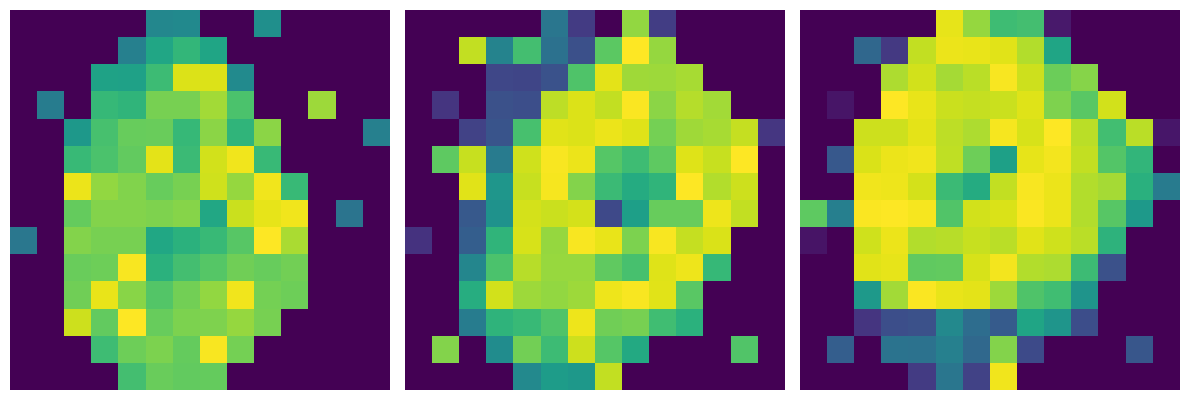

In [6]:
# Now let's apply the other transforms
all_transforms = transforms.Compose([
    # Sensor size is now (34, 34, 2)
    transforms.MergePolarities(),
    # Sensor size is now (34, 34, 1)
    transforms.CenterCrop(sensor_size=(34, 34, 1), size=28),
    # Sensor size is now (28, 28, 1)
    transforms.Downsample(spatial_factor=0.5),
    # Sensor size is now (14, 14, 1)
    transforms.ToTimesurface(dt=100000, tau=100000, sensor_size=(14, 14, 1)),
])

# Apply the transforms to the sample events
surfs = all_transforms(sample_events)
print(surfs.shape)

def visualize_surfaces(surfaces):
    n_surfaces = surfaces.shape[0]
    n_channels = surfaces.shape[1]
    fig, axs = plt.subplots(n_channels, n_surfaces, figsize=(12, 8))
    index = 0
    for i in range(n_surfaces):
        axs[index].imshow(surfs[index][0])
        axs[index].axis('off')
        index += 1
    plt.tight_layout()
    plt.show()

visualize_surfaces(surfs)

(3, 1, 34, 34)


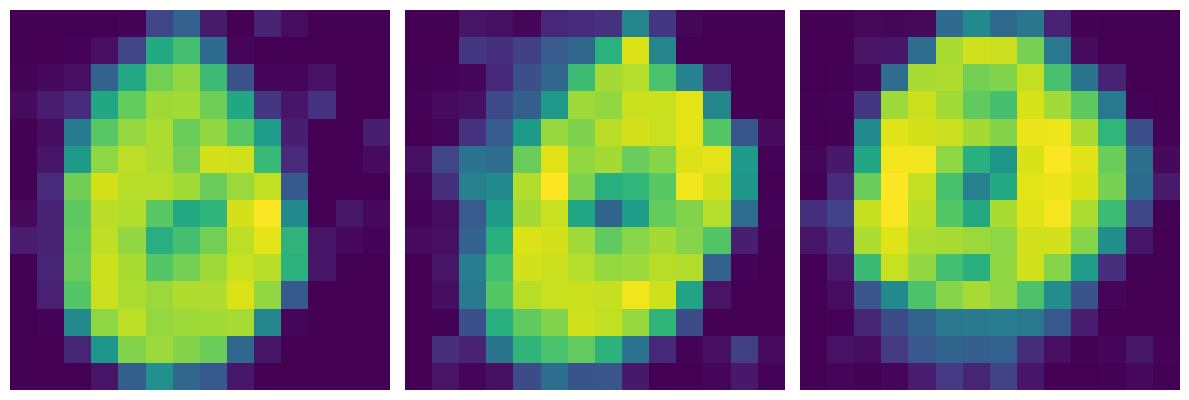

In [7]:
# If using Tonic is too complicated, let's look at an alternative using Torchvision
from torchvision import transforms as tv_transforms


selected_transforms = transforms.Compose([
    # Sensor size is now (34, 34, 2)
    transforms.MergePolarities(),
    # Sensor size is now (34, 34, 1)
    transforms.ToTimesurface(dt=100000, tau=100000, sensor_size=(34, 34, 1)),
])

# Apply the transforms to the sample events
surfs = selected_transforms(sample_events)
print(surfs.shape)

image_transforms = tv_transforms.Compose([
    # move channel dimension to the back
    lambda x: x.transpose(1, 2, 0),
    tv_transforms.ToPILImage(),
    tv_transforms.CenterCrop(28),
    tv_transforms.Resize(14),
])

cropped_images = np.stack([image_transforms(surf) for surf in surfs])


def visualize_images(images):
    n_imgs = images.shape[0]
    fig, axs = plt.subplots(1, n_imgs, figsize=(12, 8))
    index = 0
    for i in range(n_imgs):
        axs[index].imshow(images[index])
        axs[index].axis('off')
        index += 1
    plt.tight_layout()
    plt.show()

visualize_images(cropped_images)

In [8]:
pil_images.shape

NameError: name 'pil_images' is not defined